# Chlorophyll around a track

In [1]:
import os

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from numpy import datetime64, timedelta64
import numpy as np
import pandas as pd

from OceanColor.OceanColor import InRange
from OceanColor.utils import decode_L2_flagmask

In [2]:
# Replace here with your EarthData username and password
username = <earthdata username>
password = <earthdata password>

## Along Track

Let's take a Spray underwater glider mission for demonstration.
Each waypoint shown here was a glider surfacing.
If interested in more details on this data, check https://spraydata.ucsd.edu/projects/CUGN/

In [3]:
# The track is a list of waypoints, each one with a time, latitude, and longitude.
track = pd.DataFrame([
    {"time": datetime64("2017-12-11 15:00:00"), "lat": 33.3427, "lon": -118.0739},
    {"time": datetime64("2017-12-11 16:30:00"), "lat": 33.2523, "lon": -118.2601},
    {"time": datetime64("2017-12-11 15:00:00"), "lat": 33.1619, "lon": -118.4461},
    {"time": datetime64("2017-12-11 19:00:00"), "lat": 33.0715, "lon": -118.6319},
])

Let's define some searching criteria such as acceptable time difference, maximum distance, which sensor and processing level.

In [4]:
# Distance tolerance [m]
dL_tol = 10e3
# Time difference tolerance. Note, as a np.timedelta64
dt_tol = timedelta64(12, 'h')
# Which sensor? Try to change it to aqua, or terra
sensor = 'snpp'
# Data type. Try to change it to L3m
dtype = 'L2'

First we create a InRange object which will process and organize the search and download. On this example we will search on up to 3 images in parallel, defined by the npes=3.
And the NASA data will be stored in the same directory where we are running this notebook.

In [5]:
matchup = InRange(username, password, './', npes=3)

Now we initiate the actual search, defining the track of points to search around, which sensor, data type, and range in time and space considered in the search.

When you run for the first time it can take a little since it will first search for potential images with data in range, download those images and finally extract the actual pixels in the matchup.

In [6]:
matchup.search(track, sensor, dtype, dt_tol, dL_tol)

The matchup object is a generator. Let's loop along the founded objects.

In [7]:
data = pd.concat([m for m in matchup])
data = data.reset_index(drop=True)[['waypoint_id', 'lon', 'lat', 'dL', 'dt', 'chlor_a','l2_flags', 'product_name']]

Found 2412 matchs
Found 1366 matchs


Let's check which granules had data within range to our waypoints

In [8]:
data.product_name.unique()

array(['V2017345201200.L2_SNPP_OC.nc', 'V2017345215400.L2_SNPP_OC.nc'],
      dtype=object)

Let's take a glance on the first pixel found

In [9]:
data.iloc[0]

waypoint_id                                0
lon                              -118.004166
lat                                33.275707
dL                                      9868
dt                    0 days 05:13:32.292000
chlor_a                                  NaN
l2_flags                          1610613248
product_name    V2017345201200.L2_SNPP_OC.nc
Name: 0, dtype: object

How many pixels within time/space range?

We are interested in chlorophyll, so let's remove the pixels without a valid chlorophyll measurement, and count how many pixels we have.

In [10]:
data = data.dropna(axis='index', subset=['chlor_a'])
data.index.size

1190

What is the maximum chlorophyll observed nearby the Spray glider?

In [11]:
data.chlor_a.max()

19.69614028930664

This data comes with a quality flag, named l2_flags.
Let's check what is the flag of the first value.

In [12]:
data.l2_flags.iloc[0]

1610629376

That flag is a bit table, thus not easy for us to understand it if parsed as an integer.
Luckly we have a function to help to parse those flags.

In [13]:
decode_L2_flagmask(data.l2_flags.iloc[0])

['STRAYLIGHT', 'LOWLW', 'HIPOL', 'PRODFAIL']

Let's remove all pixels flagged as "HISATZEN"

In [14]:
idx = data.l2_flags.apply(lambda flag: "HISATZEN" not in decode_L2_flagmask(flag))
data = data[idx]

Let's plot and see what we got

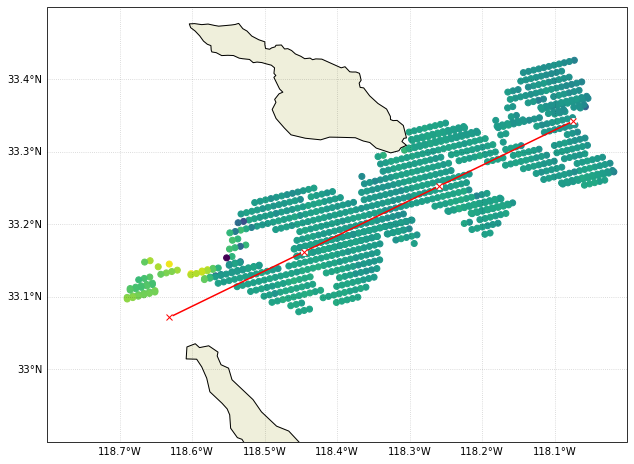

In [15]:

proj = ccrs.PlateCarree()
extent = [-118.8, -118, 32.9, 33.5]
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=proj)
# ax.plot(lon_tk1, lat_tk1, transform=proj)
# ax.plot(lon_tk2, lat_tk2, 'r', transform=proj)

ax.set_extent(extent)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
g = ax.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='dotted')
g.right_labels = False
g.top_labels = False


# ax.scatter(data.lon, data.lat, c=data.chlor_a, norm=norm,cmap=cmap_hs, s=50, transform=proj)
ax.scatter(data.lon, data.lat, c=np.log2(data.chlor_a), transform=proj)
ax.plot(track.lon, track.lat, 'r', transform=proj)
ax.plot(track.lon, track.lat, 'ow', transform=proj)
ax.plot(track.lon, track.lat, 'rx', transform=proj)